# INF552 Homework6:

Student Name : Hsin-Yu, Chang (1160173733)

In [1]:
import pandas
import numpy as np
import os
os.getcwd()

'/Users/changhsinyu/Desktop/USC2018Fall/INF552/assignment'

In [22]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import sys
sys.path.append(r'/anaconda3/pkgs/liblinear-2.21/python')
import liblinear
from liblinearutil import *
from scipy.stats import itemfreq
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import roc_auc_score
import warnings

##### Function: Normalize training data and transform test (validation) set with the same parameters (mean and standard deviation)

In [4]:
from sklearn.preprocessing import Normalizer
def Normalize(ttrainX, testX):
    normalizer = Normalizer()
    ttrainX = normalizer.fit_transform(ttrainX)
    testX = normalizer.transform(testX)
    return ttrainX, testX

##### Function: Train a L1-penalized SVM with choosing the penalty parameter by  K-fold cross validation 

In [6]:
def L1SVMSearchC(ttrainX, ttrainy, fold):
    # fold = 1
    foldgridacc = []
    paramC = [0.01, 0.1, 1, 10, 100, 1000, 10000]
    
    #skf = StratifiedKFold(n_splits = fold)
    skf = KFold(n_splits = fold)
      
    for traini, validi in skf.split(ttrainX, ttrainy):
        # print('Fold: %d' %fold)
        # fold+=1
        gidacc = []
        tX, vX = ttrainX[traini], ttrainX[validi]
        ty, vy = ttrainy[traini], ttrainy[validi]
        tX, vX = Normalize(tX, vX)
        for c in paramC:
            prob = problem(ty, tX)
            param = parameter('-s 5 -c '+str(c)+ ' -q')
            # print('C = %0.2f' % c)
            l1svm = train(prob, param) 
            vpredy, _, _ = predict(vy, vX, l1svm, '-q')
            gidacc.extend([accuracy_score(vy, vpredy)])
        
        foldgridacc.append(gidacc)
        # print('\n')  
    #find best C and train model
    foldgridacc = np.array(foldgridacc)
    foldgridacc = foldgridacc.mean(axis=0)
    bestC = np.array(paramC)[foldgridacc==max(foldgridacc)][0]
    
    #refit model with best C
    normalizer = Normalizer()
    ttrainX = normalizer.fit_transform(ttrainX)
    prob = problem(ttrainy, ttrainX)
    param = parameter('-s 5 -c '+str(bestC)+ ' -q')
    l1svm = train(prob, param) 

    return normalizer, l1svm

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

### (a) Download Breast Cancer Wisconsin (Diagnostic) Data Set:

In [40]:
wimputfile = '/Users/changhsinyu/Desktop/temp/wdbc.data.txt'
namefile  = '/Users/changhsinyu/Desktop/temp/wdbc.names.txt'
wdbc = pandas.read_csv(wimputfile, header = None)
wdbc.columns = ['ID', 'Diagnosis'] + ['fea'+str(i) for i in range(1,31)]
wdbcX = wdbc.iloc[:, 2:]

Ddict = {'B': 0, 'M': 1}
wdbcy = np.array([Ddict[d] for d in wdbc.Diagnosis])
#B-0, M-1

from sklearn.datasets import dump_svmlight_file
from sklearn.datasets import load_svmlight_file
dump_svmlight_file(wdbcX, wdbcy, '/Users/changhsinyu/Desktop/temp/wdbc.dat', zero_based=True, multilabel=False)
slwdbc = load_svmlight_file('/Users/changhsinyu/Desktop/temp/wdbc.dat')
slwdbcX = slwdbc[0]
slwdbcy = slwdbc[1]

In [171]:
wdbc.head()

,ID,Diagnosis,fea1,fea2,fea3,fea4,fea5,fea6,fea7,fea8,...,fea21,fea22,fea23,fea24,fea25,fea26,fea27,fea28,fea29,fea30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


##### Function: Split dataset to training set (80%) and test set (20%) with shuffling

In [41]:
from sklearn.utils import shuffle
import math
def TrainTest20Shuffle(data):
    
    indexM, = np.where(data[1] == 1)
    testlM = math.ceil(len(indexM)*0.2)
    tm = np.random.choice(len(indexM), size=testlM, replace=False)
    
    indexB, = np.where(data[1] == 0)
    testlB = math.ceil(len(indexB)*0.2)
    tb = np.random.choice(len(indexB), size=testlB, replace=False)
    
    testi = []
    testi.extend(indexM[tm])
    testi.extend(indexB[tb])
    testX, testy = data[0][testi], data[1][testi]

    traini = [ i for i in range(data[1].shape[0]) if i not in testi] 
    ttrainX, ttrainy = data[0][traini], data[1][traini]

    return ttrainX, ttrainy, testX, testy 

##### __>__ Encode 'Benign' = 0 and 'Malignant' = 1 to train SVM with Liblinear

In [173]:
#orginal data
itemfreq(slwdbc[1])

array([[  0., 357.],
       [  1., 212.]])

In [172]:
ttrainX, ttrainy, testX, testy = TrainTest20Shuffle(slwdbc)

In [174]:
itemfreq(ttrainy)

array([[  0., 285.],
       [  1., 169.]])

In [175]:
itemfreq(testy)

array([[ 0., 72.],
       [ 1., 43.]])

### (b) Monte-Carlo Simulation:

##### Function: Model Evaluation (Accuracy, Precision, Recall, F-score and AUC) 

In [42]:
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import roc_auc_score
def report(truey, predicty, proby):
    acc = accuracy_score(truey, predicty)
    pre = precision_score(truey, predicty, pos_label=1)
    recall = recall_score(truey, predicty, pos_label=1)
    warnings.filterwarnings("ignore")
    f1score = f1_score(truey, predicty, pos_label=1, average='weighted')
    auc = roc_auc_score(truey, proby)
    
    return [acc, pre, recall, f1score, auc]

### i. Supervised Learning 

##### Function: Monte-Carlo Simulation (n=30) with Supervised L1-penalized SVM

In [187]:
def MCsupervisedL1SVM(n, data):
    MCtrain = []
    MCtest = []
    
    for i in range(n):
        ttrainX, ttrainy, testX, testy = TrainTest20Shuffle(data)
        #5-fold CV choosing beat C and return L1-penalized SVM with best C and normalizer fitting on training set 
        normalizer, l1svm = L1SVMSearchC(ttrainX, ttrainy, 5) 
        
        #train
        ttrainX = normalizer.transform(ttrainX)
        ttpredy, _, ttproby = predict(ttrainy, ttrainX, l1svm, '-q')
        MCtrain.append(report(ttrainy, ttpredy, ttproby))
        
        #test
        testX = normalizer.transform(testX)
        tpredy, _, tproby= predict(testy, testX, l1svm, '-q')
        MCtest.append(report(testy, tpredy, tproby))

    print('The %dth Monte-Carlo Simulation\n' % n)
    print('Training Set')
    print(confusion_matrix(ttrainy, ttpredy))

    fpr, tpr, _ = roc_curve(ttrainy, ttproby)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic on Training Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
    print('Test Set')
    print(confusion_matrix(testy, tpredy))
    fpr, tpr, _ = roc_curve(testy, tproby)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic on Test Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    eva = pandas.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'AUC'])
    MCtrain = np.array(MCtrain).mean(axis=0).tolist()
    MCtest = np.array(MCtest).mean(axis=0).tolist()   
    
    eva.loc['Training Set',:] = MCtrain
    eva.loc['Test Set',:] = MCtest
    
    print('\n')
    print('Average Evaluation on Supervised Learning')
    print(eva)
    
    return eva

The 30th Monte-Carlo Simulation

Training Set
[[283   2]
 [  3 166]]


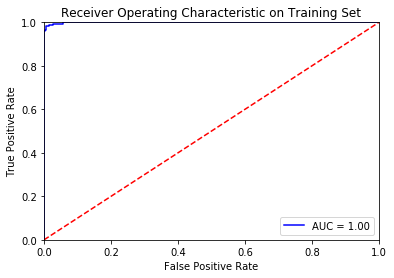

Test Set
[[71  1]
 [ 3 40]]


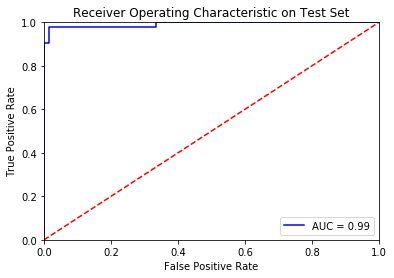



Average Evaluation on Supervised Learning
              Accuracy Precision    Recall  f1-score       AUC
Training Set  0.981938  0.988271  0.962919  0.981886  0.998349
Test Set      0.968406  0.965971  0.949612  0.968342  0.994014


In [188]:
superviseeva = MCsupervisedL1SVM(30, slwdbc)

### ii. Semi-Supervised Learning/ Self-training

##### Function: Train a L1-penalized SVM with labeling the farthest unlabeled datapoint at a time

In [53]:
def SemisupervisedL1SVM(ttrainX, ttrainy):
    #split training data into labeled and unlabeled
    labeli = []

    for c in [0,1]:
        ind, = np.where(ttrainy==c)
        labell = math.ceil(len(ind)*0.5)
        t = np.random.choice(len(ind), size=labell, replace=False)
        labeli.extend(ind[t])

    unlabeli = [i for i in range(len(ttrainy)) if i not in labeli]

    labelX = ttrainX[labeli].toarray().tolist()
    labely = ttrainy[labeli].tolist()

    unlabelX = ttrainX[unlabeli].toarray()
    unlabely = ttrainy[unlabeli]

    while unlabelX.shape[0]>0:
        normalizer, l1svm = L1SVMSearchC(np.array(labelX), np.array(labely), 5)

        weight = np.array(l1svm.get_decfun()[0])
        bias = l1svm.get_decfun()[1]
        dist2hyper = abs(unlabelX@weight+bias) 
        get = np.argpartition(dist2hyper, -1)[-1:]

        tobelabelX = normalizer.transform(unlabelX[get])
        pred, _, tproby= predict(unlabely[get], tobelabelX, l1svm, '-q')

        labelX.extend(unlabelX[get].tolist())
        labely.extend(pred)
        unlabelX = np.delete(unlabelX, get, axis = 0)
        unlabely = np.delete(unlabely, get, axis = 0)

    #Final SVM after labeling all unlabeled data
    normalizer, l1svm = L1SVMSearchC(np.array(labelX), np.array(labely), 5)
    return normalizer, l1svm

##### Function: Monte-Carlo Simulation (n=30) with Semi-Supervised L1-penalized SVM

In [60]:
def MCSemisupervisedL1SVM(n, data):
    MCtrain = []
    MCtest = []
    
    for i in range(n):
        ttrainX2, ttrainy2, testX2, testy2 = TrainTest20Shuffle(data)
        normalizer, l1svm = SemisupervisedL1SVM(ttrainX2, ttrainy2)
        
        #train
        ttrainX2 = normalizer.transform(ttrainX2)
        ttpredy, _, ttproby = predict(ttrainy2, ttrainX2, l1svm, '-q')
        MCtrain.append(report(ttrainy2, ttpredy, np.array(ttproby)*-1))
        
        #test
        testX2 = normalizer.transform(testX2)
        tpredy, _, tproby= predict(testy2, testX2, l1svm, '-q')
        MCtest.append(report(testy2, tpredy, np.array(tproby)*-1))

    print('The %dth Monte-Carlo Simulation\n' % n)
    print('Training Set')
    print(confusion_matrix(ttrainy2, ttpredy))#, rownames=['Actual'], colnames=['Predict'])
    fpr, tpr, _ = roc_curve(ttrainy2, np.array(ttproby)*-1)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic on Training Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('Test Set')
    print(confusion_matrix(testy2, tpredy))
    fpr, tpr, _ = roc_curve(testy2, np.array(tproby)*-1)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic on Test Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    eva = pandas.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'AUC'])
    MCtrain = np.array(MCtrain).mean(axis=0).tolist()
    MCtest = np.array(MCtest).mean(axis=0).tolist()   
    
    eva.loc['Training Set',:] = MCtrain
    eva.loc['Test Set',:] = MCtest
    
    print('\n')
    print('Average Evaluation on Semi-Supervised Learning')
    print(eva)
    
    return eva


The 30th Monte-Carlo Simulation

Training Set
[[283   2]
 [  9 160]]


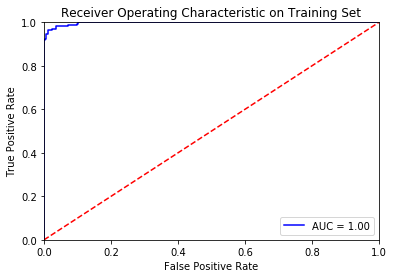

Test Set
[[71  1]
 [ 3 40]]


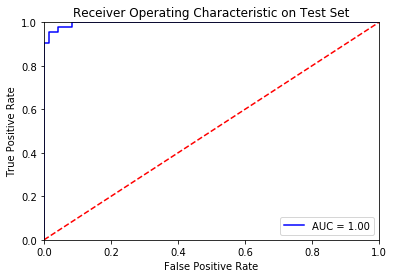

/n
Average Evaluation on Semi-Supervised Learning
              Accuracy Precision    Recall  f1-score       AUC
Training Set  0.969824  0.976579  0.941815  0.969709  0.994766
Test Set       0.96058   0.96576  0.928682  0.960391  0.992733


In [62]:
semisuperviseeva = MCSemisupervisedL1SVM(30, slwdbc)

### iii. Unsupervised Learning with Kmeans:

##### Function: Assigning label of each cluster with majority of the closest 30 datapoints

In [63]:
def clustormajority(cluscenter, X, label):
    clustermajority = []
    for clus in [0, 1]:
        center = cluscenter[clus]
        dist = np.square(center-X).mean(axis=1)
        dist = np.ravel(dist).T
        index = np.argpartition(dist, 30)[:30] #get the closet 30 datapoint
        ind = label[index].tolist()
        clustermajority.append(max(set(ind), key = ind.count))
    return pandas.Series(clustermajority)

In [64]:
def clusLabel(cluster_labels, clusmaj):
    clabel = np.empty(len(cluster_labels), dtype=int)
    for clus in [0, 1]:
        #nparray index
        index, = np.where(cluster_labels == clus)
        clabel[index] = clusmaj[clus]
    return clabel 

##### Function: Scoring the classification by distance to each cluster 

##### __>__ Using distance between datapoint and center of Cluster k to construct the classification score 

$$
\begin{align}
d(X, Cluster_j) = - Euclidean Distance(X, Center(Cluster_j))
\end{align}
$$

##### __>__ Norming it with Softmax

$$
ClassificationScore(X, Cluster_j)=\frac{e^{d(X, Cluster_j)}}{\sum^K{e^{d(X, Cluster_k)}}}
$$

In [176]:
def Kmeanssoftmax(cluscenter, X, clus1):
    dist2cent = []
    for clus in [0, 1]:
        center = cluscenter[clus]
        dist = np.sqrt(np.square(center-X).mean(axis=1))
        dist = np.ravel(dist).T
        dist2cent.append(dist.tolist())
    dist2cent = np.array(dist2cent)
    #dist2cent = 1/np.array(dist2cent)

    #softmax
    return (np.exp(-dist2cent) / np.sum(np.exp(-dist2cent), axis=0)).astype(np.float64)[clus1]
    #reciprocal
    #return (dist2cent/ np.sum(dist2cent, axis=0)).astype(np.float64)[clus1]

##### Function: Monte-Carlo Simulation (n=30) with Unsupervised Learning (K-means algorithm)

__>__ Setting n_init = 10 to make sure not being trapped in the local minimum, which means number of time running with different centroid seeds and output the best result.

In [151]:
from sklearn.cluster import KMeans
def MCUnsupervisedKmeans(n, data):
    MCtrain = []
    MCtest = []
    clus = 2
    for i in range(n):
        ttrainX3, ttrainy3, testX3, testy3 = TrainTest20Shuffle(data)
        clusterer = KMeans(n_clusters=clus, n_init = 10, random_state = i).fit(ttrainX3)
        clustormaj = clustormajority(clusterer.cluster_centers_, ttrainX3, ttrainy3)
        
        Mclus = clustormaj.index[clustormaj.values==1][0]
        

        cluster_labelstr = clusterer.predict(ttrainX3)  
        clabeltr = clusLabel(cluster_labelstr, clustormaj)       
        clussoftmaxtr = Kmeanssoftmax(clusterer.cluster_centers_, ttrainX3, Mclus)    
        MCtrain.append(report(ttrainy3, clabeltr, clussoftmaxtr))
        ##report
        #print(confusion_matrix(ttrainy3, clabeltr))

        cluster_labelste = clusterer.predict(testX3)
        clabelte = clusLabel(cluster_labelste, clustormaj)
        clussoftmaxte = Kmeanssoftmax(clusterer.cluster_centers_, testX3, Mclus)
        MCtest.append(report(testy3, clabelte, clussoftmaxte))
        ##report
        #print(confusion_matrix(testy3, clabelte))
    
    print('The %dth Monte-Carlo Simulation\n' % n)
    print('Training Set')
    print(confusion_matrix(ttrainy3, clabeltr))
    ##plot
    fpr, tpr, _ = roc_curve(ttrainy3, clussoftmaxtr)
    roc_auc = auc(fpr, tpr)
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic on Training Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print('Test Set')
    print(confusion_matrix(testy3, clabelte))
    ##plot
    fpr, tpr, _ = roc_curve(testy3, clussoftmaxte)
    roc_auc = auc(fpr, tpr)
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic on Test Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    eva = pandas.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'AUC'])
    MCtrain = np.array(MCtrain).mean(axis=0).tolist()
    MCtest = np.array(MCtest).mean(axis=0).tolist()   
    
    eva.loc['Training Set',:] = MCtrain
    eva.loc['Test Set',:] = MCtest
    
    print('\n')
    print('Average Evaluation on K-means Unsupervising Learning ')
    print(eva)
    return eva

The 30th Monte-Carlo Simulation

Training Set
[[284   1]
 [ 67 102]]


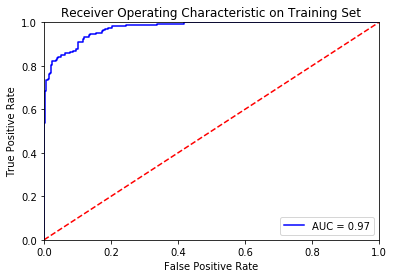

Test Set
[[72  0]
 [17 26]]


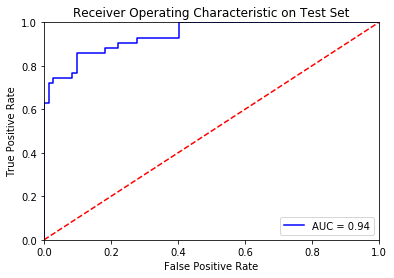



Average Evaluation on K-means Unsupervising Learning 
              Accuracy Precision   Recall  f1-score       AUC
Training Set  0.852863  0.992619  0.60927  0.842765  0.966974
Test Set      0.848986  0.991555  0.60155  0.837894  0.966947


In [152]:
kmeanseva = MCUnsupervisedKmeans(30, slwdbc)

### iv. Unsupervised Learning with Spectral Clustering:

##### Function: Cluster datapoints in Test set by calculating the average distance to each cluster, and assign it to the closest one

In [156]:
def KmeansAvgDistClus(testX, ttrainX, traincluslabel):
    dist2cent = []
    for clus in [0, 1]:
        XinClus = ttrainX[traincluslabel==clus]
        avgDist2clus = [(np.sqrt(np.square(testX[i]-XinClus).mean(axis=1))).mean() for i in range(testX.shape[0])]
        dist2cent.append(avgDist2clus)
    return np.argmin(dist2cent, axis=0)

##### Function: Monte-Carlo Simulation (n=30) with Unsupervised Learning (Spectral Clustering with rbf kernal)

In [160]:
from sklearn.cluster import SpectralClustering

In [162]:
def MCUnsupervisedSpectral(n, data):
    MCtrain = []
    MCtest = []
    clus = 2
    for i in range(n):
        ttrainX4, ttrainy4, testX4, testy4 = TrainTest20Shuffle(data)
        ttrainX4, testX4 = Normalize(ttrainX4, testX4)
        ttrainX4 =  ttrainX4.toarray()
        testX4 =  testX4.toarray()
        Speccluster = SpectralClustering(n_clusters=2, assign_labels='kmeans', affinity='rbf', eigen_tol = 1e-2, eigen_solver = 'arpack', random_state=0).fit(ttrainX4)
        Specclust_label = Speccluster.labels_

        speccluscenter = []
        for clus in [0,1]:
            speccluscenter.append(ttrainX4[Specclust_label==clus].mean(axis = 0).tolist())

        clustormaj = clustormajority(np.array(speccluscenter), ttrainX4, ttrainy4)   
        Mclus = clustormaj.index[clustormaj.values==1][0]

        cluster_labelstr = Specclust_label 
        clabeltr = clusLabel(cluster_labelstr, clustormaj)       
        clussoftmaxtr = Kmeanssoftmax(np.array(speccluscenter), ttrainX4, Mclus)    
        MCtrain.append(report(ttrainy4, clabeltr, clussoftmaxtr))
        ##report
        #print(confusion_matrix(ttrainy3, clabeltr))


        cluster_labelste = KmeansAvgDistClus(testX4, ttrainX4, Specclust_label)       
        clabelte = clusLabel(cluster_labelste, clustormaj)
        clussoftmaxte = Kmeanssoftmax(np.array(speccluscenter), testX4, Mclus)
        MCtest.append(report(testy4, clabelte, clussoftmaxte))
        ##report
        #print(confusion_matrix(testy3, clabelte))
    
    print('The %dth Monte-Carlo Simulation\n' % n)
    print('Training Set')
    print(confusion_matrix(ttrainy4, clabeltr))
    ##plot
    fpr, tpr, _ = roc_curve(ttrainy4, clussoftmaxtr)
    roc_auc = auc(fpr, tpr)
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic on Training Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print('Test Set')
    print(confusion_matrix(testy4, clabelte))
    ##plot
    fpr, tpr, _ = roc_curve(testy4, clussoftmaxte)
    roc_auc = auc(fpr, tpr)
    #import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic on Test Set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    eva = pandas.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'AUC'])
    MCtrain = np.array(MCtrain).mean(axis=0).tolist()
    MCtest = np.array(MCtest).mean(axis=0).tolist()   
    
    eva.loc['Training Set',:] = MCtrain
    eva.loc['Test Set',:] = MCtest
    print('Average Evaluation on Unsupervising Learning with Spectral Clustering ')
    print(eva)
    return eva

The 30th Monte-Carlo Simulation

Training Set
[[279   6]
 [ 51 118]]


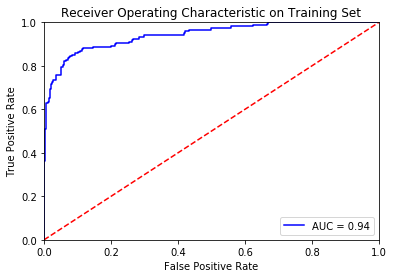

Test Set
[[72  0]
 [10 33]]


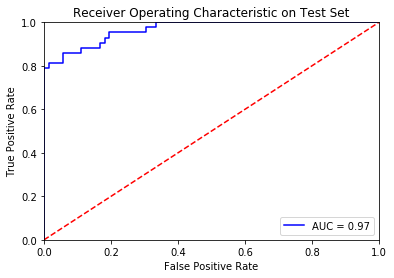

Average Evaluation on Unsupervising Learning with Spectral Clustering 
              Accuracy Precision    Recall  f1-score       AUC
Training Set  0.883113   0.95991  0.715976  0.878684  0.949225
Test Set      0.887246  0.961613  0.727907  0.883073  0.951615


In [170]:
speceva = MCUnsupervisedSpectral(30, slwdbc)

### v. Comparsion between Supervised, Semi-Supervised and Unsupervised Learning

In [207]:
ttrainn = pandas.concat([superviseeva.loc['Training Set',:],semisuperviseeva.loc['Training Set',:],kmeanseva.loc['Training Set',:],speceva.loc['Training Set',:]], axis = 1)
ttrainn.columns = ['Supervised', 'Semi-Supervised', 'Unsupervised-Kmeans', 'Unsupervised-Spectral']
print('[Average Evaluation on Training Set]')
print(ttrainn.T)

[Average Evaluation on Training Set]
                       Accuracy Precision    Recall  f1-score       AUC
Supervised             0.981938  0.988271  0.962919  0.981886  0.998349
Semi-Supervised        0.969824  0.976579  0.941815  0.969709  0.994766
Unsupervised-Kmeans    0.852863  0.992619   0.60927  0.842765  0.966974
Unsupervised-Spectral  0.883113   0.95991  0.715976  0.878684  0.949225


In [208]:
ttest = pandas.concat([superviseeva.loc['Test Set',:],semisuperviseeva.loc['Test Set',:],kmeanseva.loc['Test Set',:],speceva.loc['Test Set',:]], axis = 1)
ttest.columns = ['Supervised', 'Semi-Supervised', 'Unsupervised-Kmeans', 'Unsupervised-Spectral']
print('[Average Evaluation on Test Set]')
print(ttest.T)

[Average Evaluation on Test Set]
                       Accuracy Precision    Recall  f1-score       AUC
Supervised             0.968406  0.965971  0.949612  0.968342  0.994014
Semi-Supervised         0.96058   0.96576  0.928682  0.960391  0.992733
Unsupervised-Kmeans    0.848986  0.991555   0.60155  0.837894  0.966947
Unsupervised-Spectral  0.887246  0.961613  0.727907  0.883073  0.951615


__>__ When comparing different learning methods, we can see performance of supervised learning is slightly better than semi-supervised learning, because it involves more actual information on the label variable. Comparing with two other learning method, unsupervised learning underperforms because it makes prediction based on the similarity on the predictor variables instead of the label variable. Besides, the performance gap between supervised learning and unsupervised learning is larger than one with semi-supervised leaning, so with our average observation on 30 runs,  we can expect that training with semi-supervised method can have performance close to supervised learning, which means when we do not have enough labeled data, semi-supervised learning would be an apprpriate method to train our model and make prediction.  

## 2. Active Learning Using Support Vector Machine

### (a) Download the Banknote Authentication Data Set: 

In [2]:
imputfile = '/Users/changhsinyu/Desktop/temp/data_banknote_authentication.txt'
banknote = pandas.read_csv(imputfile, header = None)
banknote.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

banknotey = banknote['class']  
banknoteX = banknote.drop(columns = 'class')

from sklearn.datasets import dump_svmlight_file
from sklearn.datasets import load_svmlight_file
dump_svmlight_file(banknoteX, banknotey, '/Users/changhsinyu/Desktop/temp/banknote.dat', zero_based=True, multilabel=False)
slbanknote = load_svmlight_file('/Users/changhsinyu/Desktop/temp/banknote.dat')

##### Splitting dataset to training set and test set

In [177]:
btestsize = 472
btesti = np.random.choice(len(slbanknote[1]), size=btestsize, replace=False)
btestX = slbanknote[0][btesti].toarray()
btesty = slbanknote[1][btesti]

btraini = [i for i in range(len(slbanknote[1])) if i not in btesti]
bttrainX = slbanknote[0][btraini].toarray()
bttrainy = slbanknote[1][btraini]

In [179]:
print('Training Set Size: %d' %len(bttrainy))

Training Set Size: 900


In [180]:
print('Test Set Size: %d' %len(btesty))

Test Set Size: 472


### (b)

In [30]:
n=50

### i. Passive Learning

In [11]:
from sklearn.metrics import f1_score
def PassiveLearning(ttrainX, ttrainy, testX, testy):
    poolX = ttrainX
    pooly = ttrainy 
    useX = []
    usey = []
    f1error = []

    while len(pooly)>0:
        geti = np.random.choice(len(pooly), size=10, replace=False)
        useX.extend(poolX[geti].tolist())
        usey.extend(pooly[geti].tolist())
#         print(itemfreq(usey))
        poolX = np.delete(poolX, geti, axis = 0)
        pooly = np.delete(pooly, geti, axis = 0)
        normalizer, l1svm = L1SVMSearchC(np.array(useX), np.array(usey), 10)
        testX = normalizer.transform(testX)
        tpredy, _, tproby= predict(testy, testX, l1svm, '-q')
        f1error.extend([f1_score(testy, tpredy, average='weighted')])
    return f1error 

In [9]:
def PassiveLearning50(n, ttrainX, ttrainy, testX, testy):
    error = []
    for i in range(n):
        error.append(PassiveLearning(ttrainX, ttrainy, testX, testy))
    return error

In [31]:
passive = PassiveLearning50(n, bttrainX, bttrainy, btestX, btesty)

In [32]:
avgpassive = np.array(passive).mean(axis=0)

In [39]:
avgpassive

array([0.81199896, 0.85942441, 0.90475514, 0.91760939, 0.92850146,
       0.93373074, 0.93806055, 0.94190929, 0.94371543, 0.94553084,
       0.94701978, 0.94800463, 0.95035545, 0.95035332, 0.95124896,
       0.95155082, 0.95277276, 0.95389189, 0.95332069, 0.95267011,
       0.95310143, 0.95470896, 0.95340538, 0.95457635, 0.95401424,
       0.95379248, 0.95391882, 0.95383483, 0.95334791, 0.95361835,
       0.95473553, 0.95434802, 0.95455908, 0.95581401, 0.95546838,
       0.95581869, 0.95469813, 0.95469163, 0.95581677, 0.95633376,
       0.95642305, 0.95521051, 0.9571555 , 0.95763208, 0.95763656,
       0.95737721, 0.95754752, 0.95797974, 0.95741959, 0.95763263,
       0.95836451, 0.95745665, 0.95750275, 0.95659487, 0.95733034,
       0.95694009, 0.9573303 , 0.95728488, 0.95720017, 0.95693904,
       0.95874953, 0.95875248, 0.95732715, 0.95754446, 0.95806307,
       0.95866568, 0.95853644, 0.95896844, 0.95754445, 0.9581898 ,
       0.95896582, 0.95918243, 0.9597867 , 0.95935526, 0.96030

### ii. Active Learning

In [23]:
def ActiveLearning(ttrainX, ttrainy, testX, testy):
    poolX = ttrainX
    pooly = ttrainy 
    useX = []
    usey = []
    f1error = []

    #first time with random
    geti = np.random.choice(len(pooly), size=10, replace=False)
    #print(geti)
    useX.extend(poolX[geti].tolist())
    usey.extend(pooly[geti].tolist())
    # print(itemfreq(usey))
    poolX = np.delete(poolX, geti, axis = 0)
    pooly = np.delete(pooly, geti, axis = 0)
    normalizer, l1svm = L1SVMSearchC(np.array(useX), np.array(usey), 10)
    testX = normalizer.transform(testX)
    tpredy, _, tproby= predict(testy, testX, l1svm, '-q')
    f1error.extend([f1_score(testy, tpredy, average='weighted')])
    # f1error.extend([accuracy_score(testy, tpredy)])

    while len(pooly)>10:

        clos10 = []
        warnings.filterwarnings("ignore")
        randnum = (itemfreq(pooly)[:, 1]/sum(itemfreq(pooly)[:, 1])*10).round()
        
        weight = np.array(l1svm.get_decfun()[0])
        bias = l1svm.get_decfun()[1]
        dist2hyper = abs(poolX@weight+bias) 

        for c in [0,1]:
            ind, = np.where(pooly == c)
            temp = np.argpartition(dist2hyper[ind], int(randnum[c]))[:int(randnum[c])]
            clos10.extend(ind[temp].tolist())
  
        useX.extend(poolX[clos10].tolist())
        usey.extend(pooly[clos10].tolist())
        # print(itemfreq(usey))
        poolX = np.delete(poolX, clos10, axis = 0)
        pooly = np.delete(pooly, clos10, axis = 0)

        normalizer, l1svm = L1SVMSearchC(np.array(useX), np.array(usey), 10)
        testX = normalizer.transform(testX)
        tpredy, _, tproby= predict(testy, testX, l1svm, '-q')
        f1error.extend([f1_score(testy, tpredy, average='weighted')])
        # f1error.extend([accuracy_score(testy, tpredy)])
    
    #last time
    useX.extend(poolX.tolist())
    usey.extend(pooly.tolist())
    #poolX = np.delete(poolX, clos10, axis = 0)
    #pooly = np.delete(pooly, clos10, axis = 0)

    normalizer, l1svm = L1SVMSearchC(np.array(useX), np.array(usey), 10)
    testX = normalizer.transform(testX)
    tpredy, _, tproby= predict(testy, testX, l1svm, '-q')
    f1error.extend([f1_score(testy, tpredy, average='weighted')]) 
    # f1error.extend([accuracy_score(testy, tpredy)])
      
    return f1error

In [25]:
def ActiveLearning50(n, ttrainX, ttrainy, testX, testy):
    error = []
    for i in range(n):
        error.append(ActiveLearning(ttrainX, ttrainy, testX, testy))
    return error

In [34]:
active = ActiveLearning50(n, bttrainX, bttrainy, btestX, btesty)

In [35]:
avgactive = np.array(active).mean(axis=0)

In [38]:
avgactive

array([0.79766439, 0.8945031 , 0.91197213, 0.91546504, 0.92196646,
       0.92617149, 0.92898445, 0.93234111, 0.93675097, 0.9413336 ,
       0.94457451, 0.94351967, 0.94251493, 0.9461502 , 0.94418645,
       0.94070504, 0.94238818, 0.94514559, 0.94454829, 0.94706581,
       0.9475015 , 0.94676257, 0.94541052, 0.94182645, 0.94109431,
       0.94097382, 0.94511378, 0.94420215, 0.94889701, 0.9489377 ,
       0.95097698, 0.95136539, 0.95153956, 0.9509733 , 0.95205897,
       0.95179796, 0.95132016, 0.95361632, 0.95426296, 0.95434538,
       0.9550386 , 0.95573172, 0.95590564, 0.95620708, 0.95664021,
       0.95616183, 0.95654798, 0.95767175, 0.95788683, 0.959441  ,
       0.95991505, 0.95913668, 0.95883464, 0.95969943, 0.95801625,
       0.95685065, 0.95749849, 0.95775923, 0.9568967 , 0.95681182,
       0.95676861, 0.95607876, 0.95620845, 0.95543141, 0.95512955,
       0.95461101, 0.95409247, 0.95366061, 0.95322792, 0.95288356,
       0.95314248, 0.95327237, 0.95348772, 0.95318626, 0.95340

### (c) Monte Carlo Simulation with plotting Test Error versus Number of Training Instances

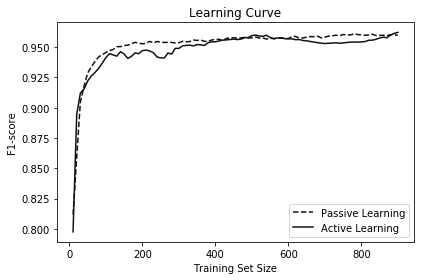

In [36]:
import matplotlib.pyplot as plt
datapoint = np.array([10*i for i in range(1,91)])
plt.plot(datapoint, avgpassive, '--', color="#111111",  label="Passive Learning")
plt.plot(datapoint, avgactive, color="#111111", label="Active Learning")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("F1-score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()